# 🌲 Dynamic-world 🌳 
## Code usage tutorial 🍂
This notebook provides an example of how this package can be used for remote monitoring of forests.

### 0. First Steps 🧐
First step is to install the dynamic-world package, you can do so by running

In [1]:
# !pip install dynamic-world

### 1. Forests 🌳 🌲 🌴
This package is based around the concept of a Forest.

Each forest (or "proyect") is stored inside a directory with a given name. Please create a directory named "forests" and inside of it a folder named "Sample".
Inside this directory there must be 2 files:
- a **forest_config.yml** (name is mandatory) which looks like this (copy and paste):
```yaml
# Name of the forest/proyect
name : Sample

# Locations of the geojson file and dcitionary with carbon factor/metric
geojson : './sample.geojson'
carbon_factor : {
    "trees" : 591.85,
    "grass" : 6,
    "bare" : 6,
    "crops" : 11.5,
    "flooded_vegetation" : 6,
    "other" : 0,
    "factor_pixel" : 100
}

# Date in which the reforestation started, in format YYYY-mm-dd
start_date: '2019-01-01'
```

- a valid [geojson](https://geojson.org/) file (named as defined in forest_config.yml) that defines the area. Copy and paste the next lines into "./forests/Sample/sample.geojson" (it's a small squared area in Peru):

```json
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -76.14143371582031,
              -8.76819770453058
            ],
            [
              -76.08770370483398,
              -8.76819770453058
            ],
            [
              -76.08770370483398,
              -8.729683981712537
            ],
            [
              -76.14143371582031,
              -8.729683981712537
            ],
            [
              -76.14143371582031,
              -8.76819770453058
            ]
          ]
        ]
      }
    }
  ]
}
```

The directory structure should be the following
```
./
└───dynamic-world-tutorial.ipynb
│
└─── forests
    │
    └─── Sample
        │   forest_config.yml
        └─  sample.geojson

```

#### 1.1 Loading a forest 🌱
To load a forest you can call use the load_config function. It will return a ForestConfig instance with some features:

In [18]:
from dynamic_world.configurations import load_config
from pathlib import Path

forest = load_config(directory_path=Path("./forests/Sample/"))
print(type(forest))

<class 'dynamic_world.configurations.ForestConfig'>


In [19]:
print("Forest name: ", forest.name)
print("Carbon factor info: ", forest.carbon_factor_info)
print("Reforestation start date: ", forest.start_date)
print("Geojson info: ", forest.geojson_info)

Forest name:  Sample
Carbon factor info:  {'trees': 591.85, 'grass': 6.0, 'bare': 6.0, 'crops': 11.5, 'flooded_vegetation': 6.0, 'other': 0.0, 'factor_pixel': 100.0}
Reforestation start date:  2019-01-01
Geojson info:  {"features": [{"geometry": {"coordinates": [[[-76.141434, -8.768198], [-76.087704, -8.768198], [-76.087704, -8.729684], [-76.141434, -8.729684], [-76.141434, -8.768198]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}], "type": "FeatureCollection"}


### 2. Calculations 📈
Given a forest and a pair of dates, we download the forest's landcover image, landcover statistics and carbon factor calculation.
By carbon factor we mean the amount of CO2 (measured in tons) that a forest stores (and therefore is not released into the atmosphere :D)

***NOTE:*** before running any of the next cells it is required that you Authenticate and Initialize the Google Earth Engine service. The easiest way is by running:

In [ ]:
import ee

ee.Authenticate() # You can skip this line if you have logged in GEE before.
ee.Initialize()

#### 2.0. Plotting the forest 🌎
To clarify what we are doing, lets plot an image of the forest using geemap

In [21]:
import geemap

In [22]:
# Loading geojson object as ee.FeatureCollection
ee_geojson = geemap.geojson_to_ee(forest.geojson_info)

# Defining the borders for DW map (must be defined as ee.Geometry)
borders = ee_geojson.geometry()

# Defining start and end dates
start_date = "2020-01-01"
end_date = "2021-01-01"

# Loading DW map and restrict it to dates and borders
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(
    start_date, end_date).filterBounds(
    borders)  # Returns ee.ImageCollection

classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.mode()).clip(borders)

In [23]:
Map = geemap.Map()
Map.add_basemap('HYBRID') # 'ROADMAP' 'SATELITE' 'TERRAIN' also supported

# Create a Sentinel-2 image composite
image = geemap.dynamic_world_s2(borders, start_date, end_date)
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
Map.addLayer(image.clip(borders), vis_params, 'Sentinel-2 image')

Map.centerObject(borders)

landcover_vis_params = {
    "min": 0,
    "max": 8,
    "palette": [
        "#419BDF",
        "#397D49",
        "#88B053",
        "#7A87C6",
        "#E49635",
        "#DFC35A",
        "#C4281B",
        "#A59B8F",
        "#B39FE1",
    ]
}

Map.addLayer(dw_composite.select("label_mode"), landcover_vis_params, "Landcover")
Map.add_legend(title="Landcover", builtin_legend="Dynamic_World")

In [24]:
Map

Map(center=[-8.748941001853282, -76.114569], controls=(WidgetControl(options=['position', 'transparent_bg'], w…

#### 2.1. Calculating the carbon factor 🌿 🌷
Using dynamic_world.calculations we can easily obtain the carbon tons not released into the atmosphere.

The first step is to retrieve the pixel_counts

In [25]:
from dynamic_world.calculations import single_date_calculation

counts = single_date_calculation(
    start_date,
    end_date,
    forest
)

print(counts)

{'NA': 750, 'bare': 14, 'built': 7265, 'crops': 11916, 'flooded_vegetation': 23, 'grass': 9262, 'shrub_and_scrub': 7188, 'trees': 216321, 'water': 4232}


Once we have the pixel counts we can easily calculate the carbon factor

In [26]:
from dynamic_world.calculations import carbon_factor_calculation

carbon_factor = carbon_factor_calculation(
    pixel_counts = counts,
    forest = forest
)

print(f"Forest {forest.name} at date {end_date} has saved {carbon_factor} tons of CO2")

Forest Sample at date 2021-01-01 has saved 1285977.39433951 tons of CO2


Note that the typical usage is to set the end_date and then setting the start_date creating a suitable interval (depends on the forest conditions, typically cloudy areas like Peru are associated with a lot of NA pixels so a larger interval is required).

#### 2.2 Downloading a TIFF image of the landcover ✏️
The forest image is stored inside a [Cloud Optimized Geotiff](https://www.cogeo.org/) file (a normal TIFF file is also produced)

In [27]:
from dynamic_world.downloads import download_single_date_image

download_single_date_image(
    start_date,
    end_date,
    forest,
    destination_folder=Path(f"./forests/Sample/{end_date}")
)

Sample_2020-01-01_2021-01-01.tif: |          | 0.00/258k (raw) [  0.0%] in 00:00 (eta:     ?)

/workspaces/dynamic-world/dynamic_world/downloads.py: 74 at 2022-08-11 08:58:27,320 - [mrv-gnome][INFO]: Successfully created TIFF file forests/Sample/2021-01-01/Sample_2020-01-01_2021-01-01.tif
/workspaces/dynamic-world/dynamic_world/downloads.py: 82 at 2022-08-11 08:58:27,500 - [mrv-gnome][INFO]: Successfully created COG file forests/Sample/2021-01-01/Sample_2020-01-01_2021-01-01.cog.tif


Input file size is 599, 430
0...10...20...30...40...50...60...70...80...90...100 - done.


PosixPath('forests/Sample/2021-01-01/Sample_2020-01-01_2021-01-01.cog.tif')

Let's plot the new file to see the results

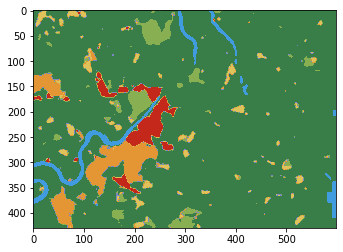

In [28]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

img=mpimg.imread("./forests/Sample/2021-01-01/Sample_2020-01-01_2021-01-01.cog.tif")
imgplot = plt.imshow(
    img,
    vmin=0,
    vmax=8,
    cmap=clrs.ListedColormap([
        "#419BDF",
        "#397D49",
        "#88B053",
        "#7A87C6",
        "#E49635",
        "#DFC35A",
        "#C4281B",
        "#A59B8F",
        "#B39FE1",
    ]))
plt.show()

#### Comment about reductions
For [reductions](https://developers.google.com/earth-engine/guides/reducers_intro) we use the Mode (polling). If a very large time interval is specified, recent changes in the forest will be masked by old pixel values. It is encouraged to use the smallest possible time intervals (at least a week is required or there may not be data). However, depending on some factors (such as the amount of clouds), specifying a small time interval may result in many NA (see mrv.calculations documentation for further info on how NA are treated when calculating the carbon factor).